https://github.com/bruceyang2012/Face-detection-with-mobilenet-ssd

**위 모델을 serving에 사용하기 위해 savedmodel로 변환하기.**

https://github.com/chuanqi305/MobileNet-SSD <- 이걸 썼어야 하는데 잘못찾고 한듯

In [130]:
import tensorflow as tf
from mn_model import mn_model
import cv2
from ssd_box_encode_decode_utils import decode_y2
import numpy as np
import matplotlib.pyplot as plt
from predictor import save_bb
import json
from keras import backend as K
import requests
%matplotlib inline
print(tf.__version__)
tf.logging.set_verbosity(3)

1.14.0


# 기존 모델 불러오기 및 테스트

In [117]:
img_height =512
img_width = 512

img_channels = 3
batch_size = 16

_CONF = 0.01 
_IOU = 0.15

n_classes = 2
class_names = ['background', 'face']

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True


voc_path = "./" 
images_path = "./" 

model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

model.load_weights('./models/ssd_mobilenet_face_epoch_25_loss0.0916.h5')

In [137]:
# model.summary()

In [138]:
img_norm = None
img = cv2.imread('./my_test/Iu.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512))  # uint8

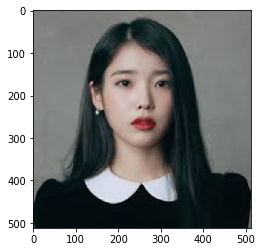

In [139]:
plt.imshow(img)

In [140]:
img = img.reshape((1,) + img.shape)  # input shape 맞춰주기

img.shape

(1, 512, 512, 3)

In [141]:
pred = model.predict(img)
pred.shape

(1, 6132, 14)

In [142]:
pred_decoded = decode_y2(pred, confidence_thresh=_CONF, iou_threshold=_IOU, normalize_coords=True, img_height=512, img_width=512)

np.array(pred_decoded).shape

(1, 2, 6)

In [143]:
save_bb('./my_test/output/', './my_test/Iu.jpeg', pred_decoded[0])

<Figure size 432x288 with 0 Axes>

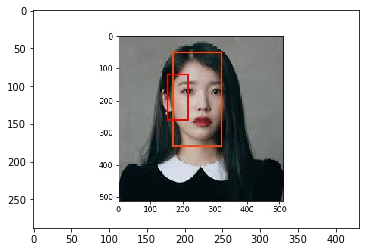

In [147]:
plt.imshow(cv2.cvtColor(cv2.imread('./my_test/output/Iu.jpeg'), cv2.COLOR_BGR2RGB))

In [148]:
print(model.input), print(model.output)

Tensor("input_3:0", shape=(?, 512, 512, 3), dtype=float32)
Tensor("detection_predictions_1/concat:0", shape=(?, ?, 14), dtype=float32)


(None, None)

# 모델 저장

In [25]:
signature = tf.saved_model.signature_def_utils.predict_signature_def(inputs={'image': model.input},
                                                                    outputs={'predicts': model.output})
# SignatureDefs 란 savedModel와  Serving을 위한 mapper.
# function의 inputs, outputs 을 식별할 수 있게 함

W0805 19:41:01.752727 4518688192 deprecation.py:323] From /Users/minhyeoklee/.pyenv/versions/3.6.7/envs/capstone/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [35]:
builder = tf.saved_model.builder.SavedModelBuilder('./my_test/test.saved_model/0001')
# version 꼭 써줘야 함

In [38]:
builder.add_meta_graph_and_variables(sess=K.get_session(), tags=[tf.saved_model.tag_constants.SERVING],
                                    signature_def_map={
                                        tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature
                                    })

builder.save()

# Request Test

In [153]:
# json serialization을 위해 ndarray -> python list
img_list = img.tolist()

# payload
payload = {
    'instances': img_list
}
%time res = requests.post('http://0.0.0.0:8501/v1/models/ssd-face:predict', json=payload)

CPU times: user 385 ms, sys: 49 ms, total: 434 ms
Wall time: 1.15 s


In [155]:
pred = np.array(json.loads(res.text)['predictions'])

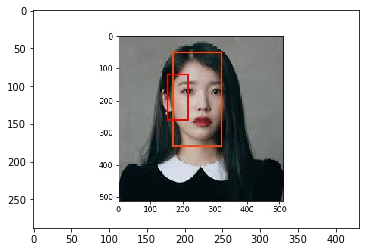

In [157]:
pred_decoded = decode_y2(pred, confidence_thresh=_CONF, iou_threshold=_IOU, normalize_coords=True, img_height=512, img_width=512)
save_bb('./my_test/output/', './my_test/Iu.jpeg', pred_decoded[0])
plt.imshow(cv2.cvtColor(cv2.imread('./my_test/output/Iu.jpeg'), cv2.COLOR_BGR2RGB))